# This is a small mod of the Newaetech tutorial Introduction to Voltage Glitchin for CW-Nano
The sole intent for this mod is to enable the students at [University of South-eastern Noway](www.usn.no) to be able to run the example on the lab \
Please check [https://github.com/newaetech](https://github.com/newaetech) for utdates :) \
[original src:](https://github.com/newaetech/chipwhisperer-jupyter/blob/c940073159c8032877e9f7b9ef852b3662c4ec02/courses/fault101/SOLN_Fault%202_1B%20-%20Introduction%20to%20Voltage%20Glitching%20with%20CWNano.ipynb)
The examle could be runned using jupyter but requres some python libraries like: chipwhisperer , matplotlib ...

# Part 2, Topic 2: Introduction to Voltage Glitching (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *While it's not as sophisticated as the ChipWhisperer Lite or ChipWhisperer Pro's glitch hardware, the ChipWhisperer Nano is also capable of glitching. In this lab, we'll do some simple glitch tests on the Nano's target board, showing how to scan through glitch settings and seeing what effect it has on the hardware.*

**LEARNING OUTCOMES:**

* Understanding how voltage glitching can be used to disrupt a target's operation
* Scanning glitch settings to determine successful ones

Digital hardware devices have certain voltage and clock requirements to function properly. If these requirements are not met, the device can fail to function, or even be damage. By shorting the voltage pins of a microcontroller for controlled, short periods of time, we can cause it to behave erratically, clearning registers and skipping instructions.  Such attacks can be immensely powerful in practice. Consider for example the following code from [newaetech - simpleserial-glitch.c ](https://github.com/newaetech/chipwhisperer/blob/develop/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch.c) :

```C
/*src: https://github.com/newaetech/chipwhisperer/blob/develop/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch.c*/
/*Line 32 .. (+ small mod..)*/
uint8_t glitch_loop(uint8_t* in)
{
    volatile uint16_t i, j;
    volatile uint32_t cnt;
    cnt = 0;
    
    trigger_high();        /* Chipwhisper starts VDD Glitching    */
                           /* One of the output pins is set high  */

    /* Glitch Victim Code */
    for(i=0; i<50; i++){
        for(j=0; j<50; j++){
            cnt++;
        }
    }
   
    trigger_low();        /* Chipwhisper Stop VDD Glitching (Dont kill the serial output..) */
    
                                              /* Python listen for serial data using        */
                                              /* val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=100)  */
    simpleserial_put('r', 4, (uint8_t*)&cnt); /* Python reieves val['payload']             */

                                              /* Validate the result before exiting      */
    return (cnt != 2500);                     /* Python recieves val['valid'] True/False */
```

### Glitch Hardware

The ChipWhisperer Nano's glitch setup is pretty simple. Like its bigger brothers, the Lite and the Pro, it uses a MOSFET to short the microcontroller's voltage supply to ground:
Some new chip-whisper nano cards needs to be modifyed to produce sucessfull glitching.
( The new resistor was 5.6 Ohm [more info on github](https://github.com/newaetech/chipwhisperer/issues/419#issuecomment-1262053220)

![Original vs Modifyed CW-Nano](./mod_glitch.png)

For the Nano, `Glitch In` is controlled by 2 parameters:

1. `scope.glitch.ext_offset` - The glitch will be inserted roughly `8.3ns * scope.glitch.ext_offset`
1. `scope.glitch.repeat`     - The glitch will be inserted for roughly `8.3ns * scope.glitch.repeat`

During this lab, we'll be varying these parameters to see if we can get the target to mess up a calculation that it's doing.

In [1]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
SS_VER = 'SS_VER_2_1'

In [2]:
%run "Setup_Generic.ipynb"


INFO: Found ChipWhisperer😍


Program the Victim microcontroller STM32F04xxx

In [4]:
fw_path="simpleserial-glitch-CWNANO.hex"
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 7435 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 7435 bytes


In [4]:
scope.io.clkout = 7.5E6
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

In [5]:
scope

ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 62
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = high_z
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = bytearray(b'\x01\x00\x00\x00')
adc        = <class 'dict'>
glitch     = <class 'dict'>

In [6]:
import struct
reboot_flush()
scope.glitch.repeat = 160
scope.glitch.ext_offset =100

scope.arm()
target.simpleserial_write("g", bytearray([]))
scope.capture()
val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=100)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']
    gcnt = struct.unpack("<I", val['payload'])[0]
    print("gcnt:" , gcnt)
print(val)

gcnt: 2500
{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}


In [26]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["repeat", "ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

Some tips for finding good glitches:

1. This is a VCC line that we're shorting, so there's going to be stuff fighting against us. If your glitch is too short, it might not have any effect
1. Likewise, if your glitch is too long, the target will always crash. There's typically a small band where you're able to affect the target, but it won't always crash it.
1. Be patient. Glitching can be somewhat inconsistant, so don't be discouraged if it takes a while to see some success!

<IPython.core.display.Javascript object>


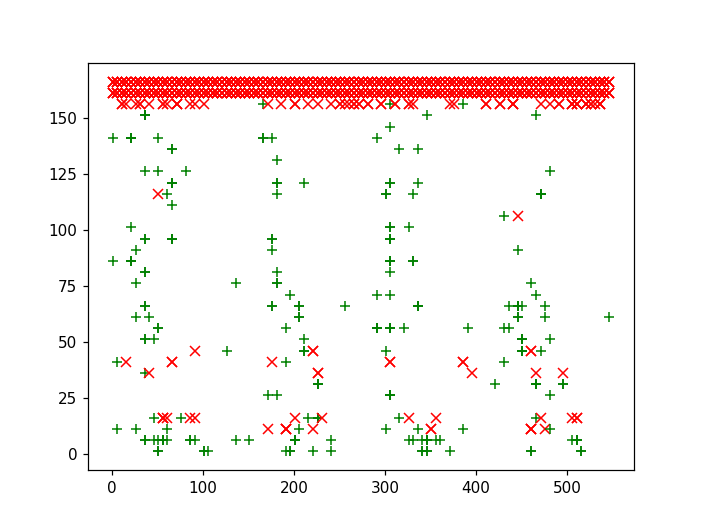

In [30]:
%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()

In [31]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct
import time

g_step = 5

gc.set_global_step(g_step)
gc.set_range("repeat", 1, 170)
gc.set_range("ext_offset", 1, 550)
scope.glitch.repeat = 0

reboot_flush()
sample_size = 1
for glitch_setting in gc.glitch_values():
    target.flush()
    reboot_flush

    scope.glitch.repeat = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[1]

    successes = 0
    resets = 0
    
    for i in range(3):
            
        scope.arm()
        #Do glitch loop
        target.simpleserial_write("g", bytearray([]))
        
        ret = scope.capture()
        
        val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
        
        if ret:
            print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
            plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
            fig.canvas.draw()
            resets += 1

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                reboot_flush()
                gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
                plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
                fig.canvas.draw()
                resets += 1
            else:
                gcnt = struct.unpack("<I", val['payload'])[0]
                
                if gcnt != 2500: #for loop check
                    gc.add("success", (scope.glitch.repeat, scope.glitch.ext_offset))
                    print(gcnt)
                    plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, '+g', alpha=1)
                    fig.canvas.draw()
                    successes += 1
                else:
                    gc.add("normal", (scope.glitch.repeat, scope.glitch.ext_offset))
                    
    if successes > 0:                
        print("successes = {}, resets = {}, repeat = {}, ext_offset = {}".format(successes, resets, scope.glitch.repeat, scope.glitch.ext_offset))
print("Done glitching")

(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 2, resets = 0, repeat = 1, ext_offset = 51


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 2, resets = 0, repeat = 1, ext_offset = 101


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 1, ext_offset = 106


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452
successes = 1, resets = 0, repeat = 1, ext_offset = 191


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 1, ext_offset = 196


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 1, ext_offset = 221


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 1, ext_offset = 241


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 2, resets = 0, repeat = 1, ext_offset = 341


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 2, resets = 0, repeat = 1, ext_offset = 346


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 1, ext_offset = 371


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 1, ext_offset = 461


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 2, resets = 0, repeat = 1, ext_offset = 516


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 2, resets = 0, repeat = 6, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 1, resets = 0, repeat = 6, ext_offset = 46


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178
successes = 1, resets = 0, repeat = 6, ext_offset = 51


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178
successes = 3, resets = 0, repeat = 6, ext_offset = 56


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 6, ext_offset = 61


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 2, resets = 0, repeat = 6, ext_offset = 86


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 6, ext_offset = 91


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501
successes = 1, resets = 0, repeat = 6, ext_offset = 136


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 6, ext_offset = 151


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 3, resets = 0, repeat = 6, ext_offset = 201


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 6, ext_offset = 241


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177
successes = 1, resets = 0, repeat = 6, ext_offset = 326


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177
successes = 1, resets = 0, repeat = 6, ext_offset = 331


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 1, resets = 0, repeat = 6, ext_offset = 341


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 3, resets = 0, repeat = 6, ext_offset = 346


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498
successes = 1, resets = 0, repeat = 6, ext_offset = 356


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 6, ext_offset = 361


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453
successes = 1, resets = 0, repeat = 6, ext_offset = 506


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 3, resets = 0, repeat = 6, ext_offset = 511


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 11, ext_offset = 6


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 11, ext_offset = 26


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 11, ext_offset = 61


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 11, ext_offset = 206


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 11, ext_offset = 301


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 11, ext_offset = 336


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 11, ext_offset = 386


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 11, ext_offset = 481


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 16, ext_offset = 46


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 16, ext_offset = 76


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452
successes = 1, resets = 0, repeat = 16, ext_offset = 216


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 3, resets = 0, repeat = 16, ext_offset = 226


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 16, ext_offset = 316


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 16, ext_offset = 466


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452
successes = 1, resets = 0, repeat = 26, ext_offset = 171


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 26, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 3, resets = 0, repeat = 26, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 26, ext_offset = 481


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 3, resets = 0, repeat = 31, ext_offset = 226


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 31, ext_offset = 421


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 3, resets = 0, repeat = 31, ext_offset = 466


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 2, resets = 0, repeat = 31, ext_offset = 496


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 36, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 41, ext_offset = 6


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 41, ext_offset = 191


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 41, ext_offset = 431


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 46, ext_offset = 126


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 2, resets = 0, repeat = 46, ext_offset = 211


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 46, ext_offset = 301


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 3, resets = 0, repeat = 46, ext_offset = 451


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 46, ext_offset = 471


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178
successes = 2, resets = 0, repeat = 51, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 51, ext_offset = 46


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 51, ext_offset = 211


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 3, resets = 0, repeat = 51, ext_offset = 451


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 51, ext_offset = 481


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 2, resets = 0, repeat = 56, ext_offset = 51


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 56, ext_offset = 191


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 3, resets = 0, repeat = 56, ext_offset = 291


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 3, resets = 0, repeat = 56, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 56, ext_offset = 321


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 56, ext_offset = 391


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501
successes = 1, resets = 0, repeat = 56, ext_offset = 431


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 56, ext_offset = 436


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 61, ext_offset = 26


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 61, ext_offset = 41


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 2, resets = 0, repeat = 61, ext_offset = 206


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 61, ext_offset = 446


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 61, ext_offset = 476


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877176
successes = 1, resets = 0, repeat = 61, ext_offset = 546


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 2, resets = 0, repeat = 66, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 66, ext_offset = 176


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2452


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 2, resets = 0, repeat = 66, ext_offset = 206


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 66, ext_offset = 256


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 3, resets = 0, repeat = 66, ext_offset = 336


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453
successes = 1, resets = 0, repeat = 66, ext_offset = 436


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501
successes = 3, resets = 0, repeat = 66, ext_offset = 446


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 66, ext_offset = 451


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 66, ext_offset = 476


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 71, ext_offset = 196


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 71, ext_offset = 291


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 71, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 71, ext_offset = 466


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 76, ext_offset = 26


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 76, ext_offset = 136


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 76, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 76, ext_offset = 461


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 2, resets = 0, repeat = 81, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 81, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 81, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 86, ext_offset = 1


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 3, resets = 0, repeat = 86, ext_offset = 21


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 3, resets = 0, repeat = 86, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 2, resets = 0, repeat = 86, ext_offset = 331


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 91, ext_offset = 26


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 91, ext_offset = 176


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 91, ext_offset = 446


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 2, resets = 0, repeat = 96, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 3, resets = 0, repeat = 96, ext_offset = 66


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 96, ext_offset = 176


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 3, resets = 0, repeat = 96, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 101, ext_offset = 21


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 2, resets = 0, repeat = 101, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 101, ext_offset = 326


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 106, ext_offset = 431


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 111, ext_offset = 66


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 116, ext_offset = 61


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 116, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 2, resets = 0, repeat = 116, ext_offset = 301


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 116, ext_offset = 331


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2453


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 3, resets = 0, repeat = 116, ext_offset = 471


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 3, resets = 0, repeat = 121, ext_offset = 66


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 121, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 121, ext_offset = 211


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877177


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 2, resets = 0, repeat = 121, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 121, ext_offset = 336


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 1, resets = 0, repeat = 126, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 126, ext_offset = 51


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


68035
successes = 1, resets = 0, repeat = 126, ext_offset = 81


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2453
successes = 1, resets = 0, repeat = 126, ext_offset = 481


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2452
successes = 1, resets = 0, repeat = 131, ext_offset = 181


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2498


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 2, resets = 0, repeat = 136, ext_offset = 66


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 136, ext_offset = 316


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 136, ext_offset = 336


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 141, ext_offset = 1


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 3, resets = 0, repeat = 141, ext_offset = 21


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 141, ext_offset = 51


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


2501


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 2, resets = 0, repeat = 141, ext_offset = 166


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 141, ext_offset = 176


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 141, ext_offset = 291


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877177
successes = 1, resets = 0, repeat = 146, ext_offset = 306


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10


536877178


(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


536877178
successes = 3, resets = 0, repeat = 151, ext_offset = 36


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2498
successes = 1, resets = 0, repeat = 151, ext_offset = 346


(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 65 01 10 42 00')


2501
successes = 1, resets = 0, repeat = 151, ext_offset = 466


(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

2501
successes = 1, resets = 0, repeat = 156, ext_offset = 166


(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

536877177
successes = 1, resets = 0, repeat = 156, ext_offset = 306


(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

2501
successes = 1, resets = 0, repeat = 156, ext_offset = 386


(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start 

(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected length 69, 4
(ChipWhisperer Target WARNING|File SimpleSerial2.py:377) Unexpected start to command 82
(ChipWhisperer Target WARNING|File SimpleSerial2.py:410) Unexpected

Done glitching


In [ ]:
val

<IPython.core.display.Javascript object>


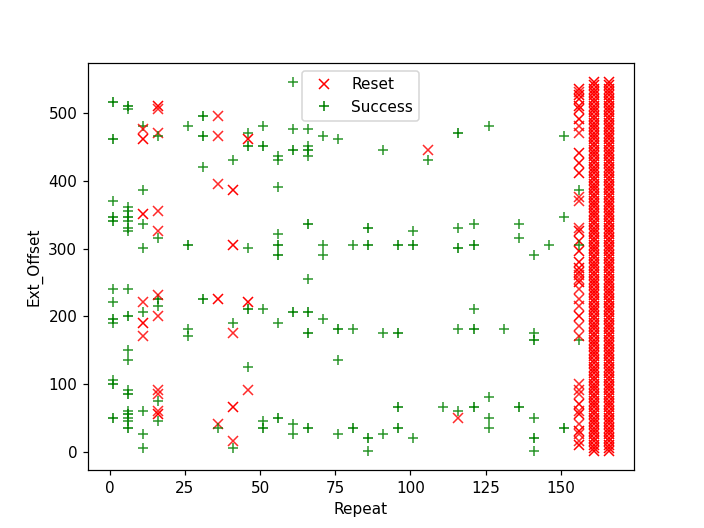

In [32]:
%matplotlib notebook
gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None})

In [ ]:
scope.dis()
target.dis()

Unlike the other ChipWhisperers, the Nano doesn't have sychronous glitching. This means that `ext_offset` is a mixture of both the offset within the clock cycle, which affects glitch success, and ext_offset, which affects which instruction is being glitched. As such, ext_offset settings you find in this lab won't be directly applicable to other labs. That being said, good ranges for repeat and the success rate of glitches still gives valuable information that you can apply to other labs.